# Compartment-model-based scale-down design
This notebook combines the metabolic model of overflow in E. coli by Xu et al. 1999 with the compartment model by Nadal-Rey et al. 2021, to simulate oxygen and substrate gradients and design scale-down experiments

## Imports

In [1]:
from cmodels.cc_cmodel import cc_cmodel
from cmodels.cc_cmodel_sol import cc_cmodel_sol
from mmodels.xu_bb.cc_xu_bb import cc_xu_bb

In [2]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [3]:
plt.rcParams['font.size'] = 7
plt.rcParams.update({'font.sans-serif':'Arial'})
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.rcParams['xtick.major.pad']= 2
plt.rcParams['ytick.major.pad']= 2

plt.rcParams['axes.labelpad']= 2

In [4]:
# Loading compartment model
RTD_LS_9 = cc_cmodel(excel_path='cmodels/cmodel_files/RTD_LS/9_RTD_LS.xlsx')

## Compartment model simulations

### Defining metabolic model parameters

In [5]:
complex_mmodel = cc_xu_bb(
    strain_id='Xu et al. 1999 literature strain',
    strain_description='WT E. coli'
)

complex_mmodel.define_strain_params(
    qS_max=np.mean([0.78433, 0.76553]),
    qm_max=0,
    qA_c_max=np.mean([0.03444,0.03726]),
    qO_max=np.mean([6.7453,6.9238]),
    Ysx_ox=np.mean([0.43349, 0.44498]),
    Ysx_of=np.mean([0.43349, 0.44498]),
    Ysa=0.667,
    Yax=0.0,
    Ki_s=100,
    Ks=0.05,
    Ka=0.05,
    Ki_o=100
)

### Solving compartment model

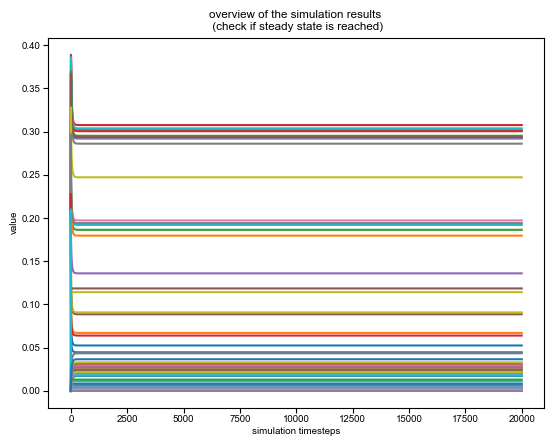

In [6]:
y0_1d = [
    0.0, #S 
    0.2095, #O
    0 #A
    ]

# multiply initial values with the number of compartments
y0 = y0_1d*len(RTD_LS_9.CompVolumes)
# simulation time
t_eval=np.linspace(0,40,20001)
# Biomass concentration 
X = 45 # to keep things consistent: A biomass concentration of 40 g/L was chosen for Ys = 0.5; hence Ysx = 0.52 should result in 41.6. This is to keep the glucose feed rate constant accross different examples. 
# Growth rate for the fed-batch
mu_set = 0.05
# Liquid volume in the whole reactor
VL = (RTD_LS_9.CompVolumes.CompVol - RTD_LS_9.CompVolumes.CompVol*RTD_LS_9.GH.GH).sum()
# Biomass yield
Ysx = complex_mmodel.Ysx_ox
# Glucose feed rate
Fs_feed = 350000
# compartment model instance
cmodel = RTD_LS_9

RTD_sol = cc_cmodel_sol(
    y0 = y0,
    t_eval = t_eval, 
    mmodel = complex_mmodel, 
    cmodel = cmodel, 
    X = X, 
    Fs_feed = Fs_feed
)

### Plotting results in compartment map

In [7]:
def highlight_compartment(RTD_sol, ax, highlighted_comp):
        
    solution = "S [g/L]"

    cmap = mpl.cm.get_cmap('rainbow')
    # for colormap normalization
    vmin = 0
    vmax = np.round(RTD_sol.sol_df[solution].max()*1.05,2)

    ax.set_xlim(0,2)
    ax.set_ylim(0,11)
    ax.set_xlabel('radius (m)')
    ax.set_ylabel('height (m)')
    ax.set_title(solution)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    for i in RTD_sol.cmodel['CompMap'].index:
        Xmin = RTD_sol.cmodel['CompMap'].iloc[i].X_min
        Xmax = RTD_sol.cmodel['CompMap'].iloc[i].X_max
        Ymin = RTD_sol.cmodel['CompMap'].iloc[i].Y_min
        Ymax = RTD_sol.cmodel['CompMap'].iloc[i].Y_max

        compartment_id = int(RTD_sol.cmodel['CompMap'].iloc[i].Zone-1)

        value = list(RTD_sol.sol_df[solution])[compartment_id]
        color_norm = max(0,value-norm.vmin)/(norm.vmax-norm.vmin)
        
        if compartment_id == int(highlighted_comp-1):
        
            pp = mpl.pyplot.Rectangle(xy=(Xmin,Ymin), width=Xmax-Xmin, height=Ymax-Ymin,linewidth=0,edgecolor='#000000',facecolor=cmap(color_norm))
            ax.add_patch(pp)
            
        
    CompMap = RTD_sol.cmodel['CompMap']
            
    for zone in CompMap.Zone.unique():
        # find unique X_min-X_max pairs for a given zone
        unique_X = CompMap[CompMap['Zone'] == zone].drop_duplicates(subset=['X_min','X_max'])

        for i in range(0,len(unique_X)):
            X_min = unique_X.iloc[i].X_min
            X_max = unique_X.iloc[i].X_max
            Y_min = CompMap[(CompMap['Zone'] == zone) & (CompMap['X_min'] == X_min) & (CompMap['X_max'] == X_max)].Y_min.min()
            Y_max = CompMap[(CompMap['Zone'] == zone) & (CompMap['X_min'] == X_min) & (CompMap['X_max'] == X_max)].Y_max.max()

            ax.plot([X_min,X_max],[Y_min,Y_min],color='black')
            ax.plot([X_min,X_max],[Y_max,Y_max],color='black')

        # find unique Y_min-Y_max pairs for a given zone
        unique_Y = CompMap[CompMap['Zone'] == zone].drop_duplicates(subset=['Y_min','Y_max'])

        for i in range(0,len(unique_Y)):
            Y_min = unique_Y.iloc[i].Y_min
            Y_max = unique_Y.iloc[i].Y_max
            X_min = CompMap[(CompMap['Zone'] == zone) & (CompMap['Y_min'] == Y_min) & (CompMap['Y_max'] == Y_max)].X_min.min()
            X_max = CompMap[(CompMap['Zone'] == zone) & (CompMap['Y_min'] == Y_min) & (CompMap['Y_max'] == Y_max)].X_max.max()

            ax.plot([X_min,X_min],[Y_min,Y_max],color='black')
            ax.plot([X_max,X_max],[Y_min,Y_max],color='black')

In [8]:
def plot_variabel_in_reactor_compartment(RTD_sol, fig, ax, variable_string, vmin, v_max, cmap, cmap_ax):
        
    solution = variable_string

    cmap = cmap
    # for colormap normalization
    vmin = vmin
    vmax = v_max

    ax.set_xlim(0,2)
    ax.set_ylim(0,11)
    ax.set_xlabel('radius (m)')
    ax.set_ylabel('height (m)')
    ax.set_title(solution)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap), cax=cmap_ax)

    for i in RTD_sol.cmodel['CompMap'].index:
        Xmin = RTD_sol.cmodel['CompMap'].iloc[i].X_min
        Xmax = RTD_sol.cmodel['CompMap'].iloc[i].X_max
        Ymin = RTD_sol.cmodel['CompMap'].iloc[i].Y_min
        Ymax = RTD_sol.cmodel['CompMap'].iloc[i].Y_max

        compartment_id = int(RTD_sol.cmodel['CompMap'].iloc[i].Zone-1)

        value = list(RTD_sol.sol_df[solution])[compartment_id]
        color_norm = max(0,value-norm.vmin)/(norm.vmax-norm.vmin)
        
        pp = mpl.pyplot.Rectangle(xy=(Xmin,Ymin), width=Xmax-Xmin, height=Ymax-Ymin,linewidth=0,edgecolor='#000000',facecolor=cmap(color_norm))
        ax.add_patch(pp)
            
        
    CompMap = RTD_sol.cmodel['CompMap']
            
    for zone in CompMap.Zone.unique():
        # find unique X_min-X_max pairs for a given zone
        unique_X = CompMap[CompMap['Zone'] == zone].drop_duplicates(subset=['X_min','X_max'])

        for i in range(0,len(unique_X)):
            X_min = unique_X.iloc[i].X_min
            X_max = unique_X.iloc[i].X_max
            Y_min = CompMap[(CompMap['Zone'] == zone) & (CompMap['X_min'] == X_min) & (CompMap['X_max'] == X_max)].Y_min.min()
            Y_max = CompMap[(CompMap['Zone'] == zone) & (CompMap['X_min'] == X_min) & (CompMap['X_max'] == X_max)].Y_max.max()

            ax.plot([X_min,X_max],[Y_min,Y_min],color='black')
            ax.plot([X_min,X_max],[Y_max,Y_max],color='black')

        # find unique Y_min-Y_max pairs for a given zone
        unique_Y = CompMap[CompMap['Zone'] == zone].drop_duplicates(subset=['Y_min','Y_max'])

        for i in range(0,len(unique_Y)):
            Y_min = unique_Y.iloc[i].Y_min
            Y_max = unique_Y.iloc[i].Y_max
            X_min = CompMap[(CompMap['Zone'] == zone) & (CompMap['Y_min'] == Y_min) & (CompMap['Y_max'] == Y_max)].X_min.min()
            X_max = CompMap[(CompMap['Zone'] == zone) & (CompMap['Y_min'] == Y_min) & (CompMap['Y_max'] == Y_max)].X_max.max()

            ax.plot([X_min,X_min],[Y_min,Y_max],color='black')
            ax.plot([X_max,X_max],[Y_min,Y_max],color='black')

In [9]:
def plot_reactor(RTD_sol, ax):
    
    yellow_cb = '#FFC107'
    blue_cb = '#1E88E5'
    red_cb = '#D81B60'

    ax.set_xlim(0,2)
    ax.set_ylim(0,11)
    ax.set_xlabel('radius (m)')
    ax.set_ylabel('height (m)')

    for i in RTD_sol.cmodel['CompMap'].index:
        Xmin = RTD_sol.cmodel['CompMap'].iloc[i].X_min
        Xmax = RTD_sol.cmodel['CompMap'].iloc[i].X_max
        Ymin = RTD_sol.cmodel['CompMap'].iloc[i].Y_min
        Ymax = RTD_sol.cmodel['CompMap'].iloc[i].Y_max

        compartment_id = int(RTD_sol.cmodel['CompMap'].iloc[i].Zone-1)
        
        # Starvation
        # if RTD_sol.sol_df["qS [g/g/h]"][compartment_id] < 0.04:
        if RTD_sol.sol_df["qS [g/g/h]"][compartment_id] < 0.05*complex_mmodel.qS_max:
            pp = mpl.pyplot.Rectangle(xy=(Xmin,Ymin), width=Xmax-Xmin, height=Ymax-Ymin,linewidth=0,edgecolor='#000000',facecolor=blue_cb)
            ax.add_patch(pp)
        elif RTD_sol.sol_df["qS_of [g/g/h]"][compartment_id] > 0.00001:
            pp = mpl.pyplot.Rectangle(xy=(Xmin,Ymin), width=Xmax-Xmin, height=Ymax-Ymin,linewidth=0,edgecolor='#000000',facecolor=red_cb)
            ax.add_patch(pp)
        else:
            pp = mpl.pyplot.Rectangle(xy=(Xmin,Ymin), width=Xmax-Xmin, height=Ymax-Ymin,linewidth=0,edgecolor='#000000',facecolor=yellow_cb)
            ax.add_patch(pp)
        

    CompMap = RTD_sol.cmodel['CompMap']
            
    for zone in CompMap.Zone.unique():
        # find unique X_min-X_max pairs for a given zone
        unique_X = CompMap[CompMap['Zone'] == zone].drop_duplicates(subset=['X_min','X_max'])

        for i in range(0,len(unique_X)):
            X_min = unique_X.iloc[i].X_min
            X_max = unique_X.iloc[i].X_max
            Y_min = CompMap[(CompMap['Zone'] == zone) & (CompMap['X_min'] == X_min) & (CompMap['X_max'] == X_max)].Y_min.min()
            Y_max = CompMap[(CompMap['Zone'] == zone) & (CompMap['X_min'] == X_min) & (CompMap['X_max'] == X_max)].Y_max.max()

            ax.plot([X_min,X_max],[Y_min,Y_min],color='black')
            ax.plot([X_min,X_max],[Y_max,Y_max],color='black')

        # find unique Y_min-Y_max pairs for a given zone
        unique_Y = CompMap[CompMap['Zone'] == zone].drop_duplicates(subset=['Y_min','Y_max'])

        for i in range(0,len(unique_Y)):
            Y_min = unique_Y.iloc[i].Y_min
            Y_max = unique_Y.iloc[i].Y_max
            X_min = CompMap[(CompMap['Zone'] == zone) & (CompMap['Y_min'] == Y_min) & (CompMap['Y_max'] == Y_max)].X_min.min()
            X_max = CompMap[(CompMap['Zone'] == zone) & (CompMap['Y_min'] == Y_min) & (CompMap['Y_max'] == Y_max)].X_max.max()

            ax.plot([X_min,X_min],[Y_min,Y_max],color='black')
            ax.plot([X_max,X_max],[Y_min,Y_max],color='black')

M:\Documents\_phd\_data_analysis_and_documentation\Paper4_Oxygen_scale-down\GitHub_repo\compartment_model\cmodels\cc_cmodel_sol.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = mpl.pyplot.subplots(figsize=(2.5, 11))


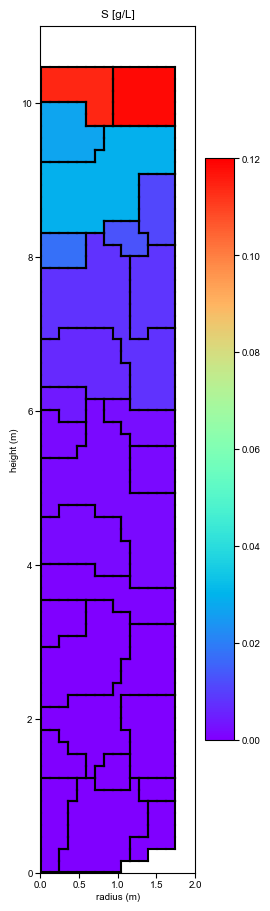

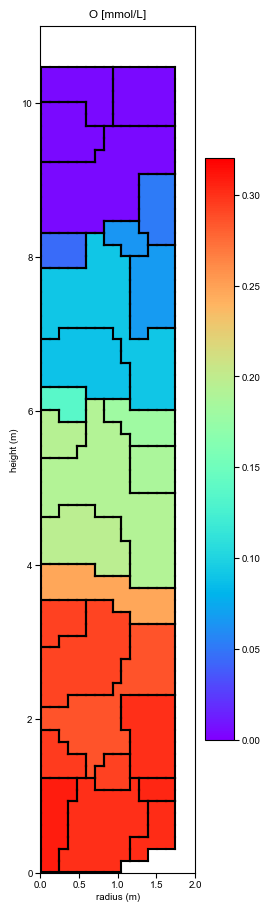

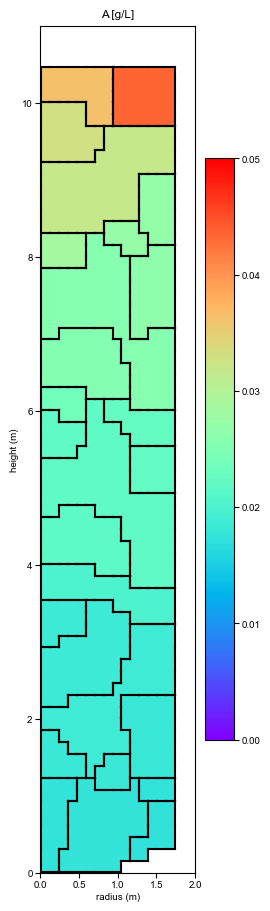

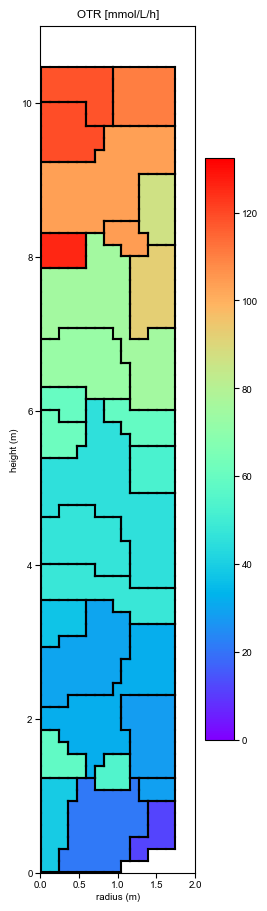

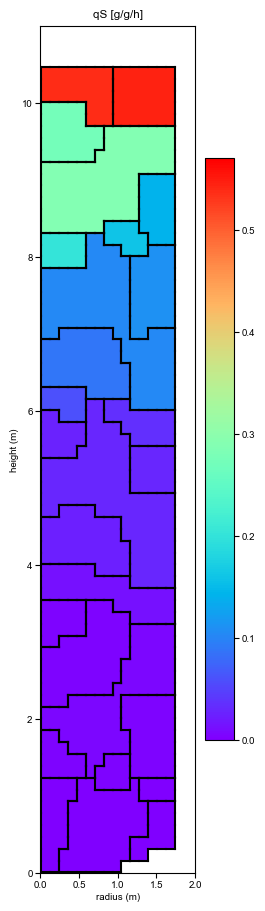

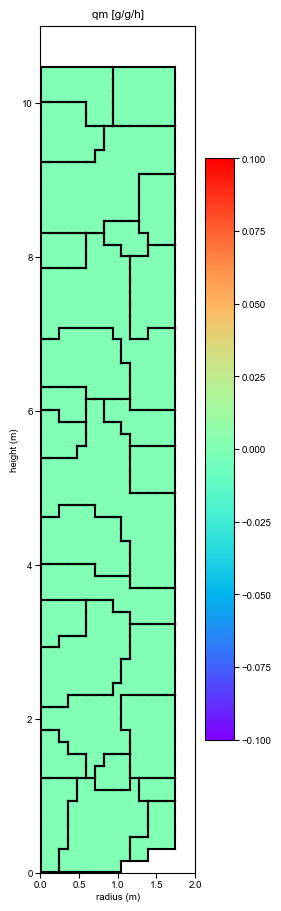

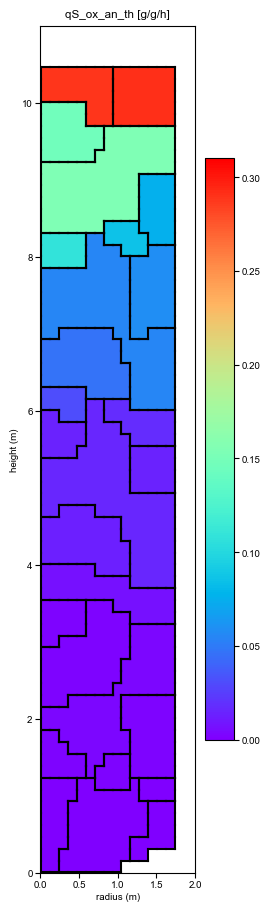

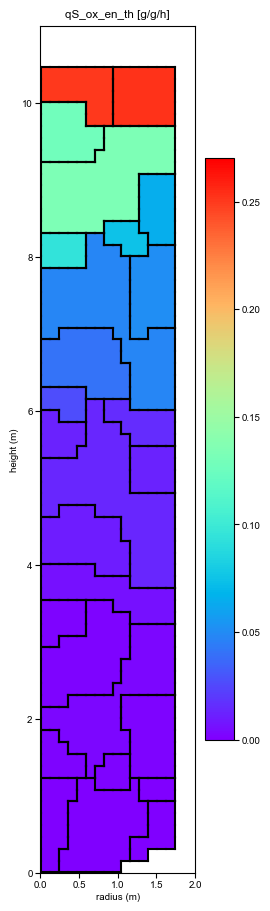

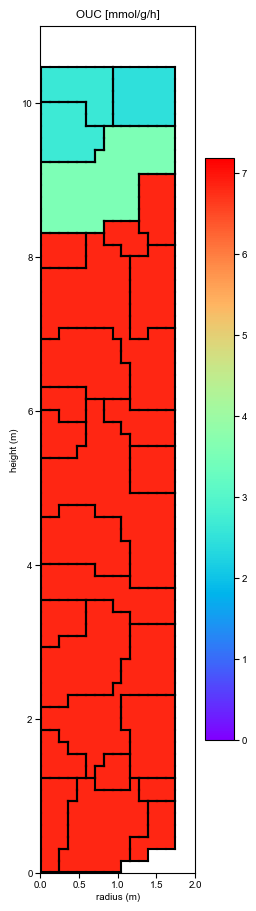

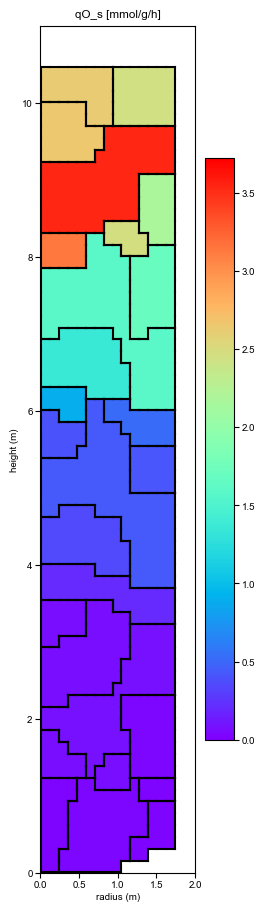

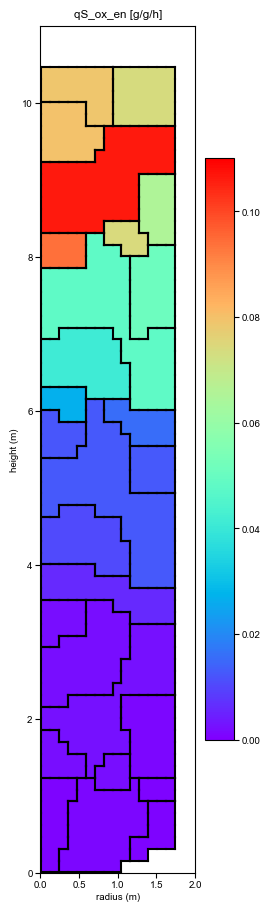

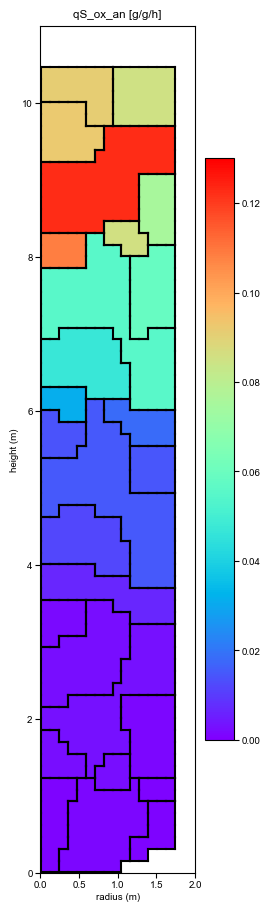

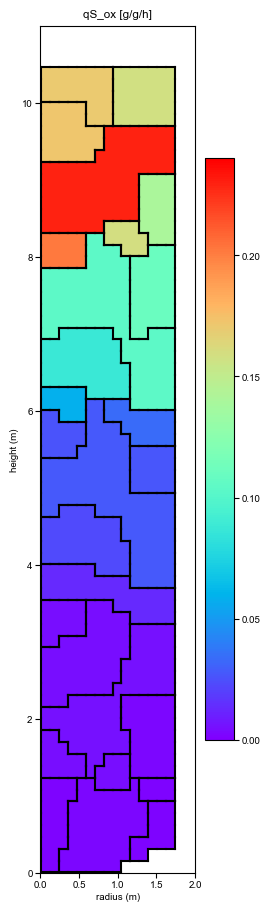

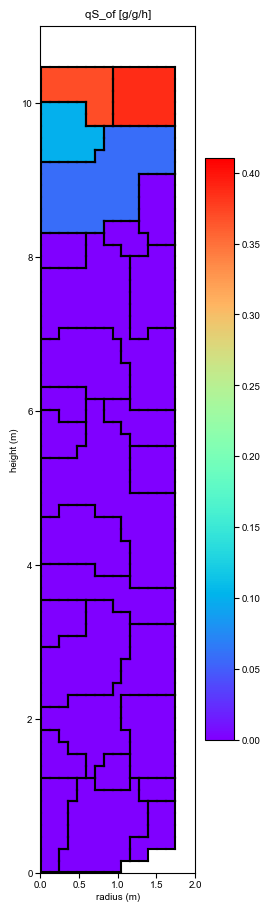

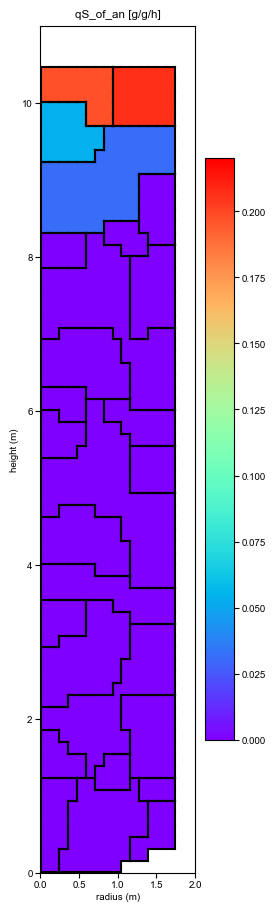

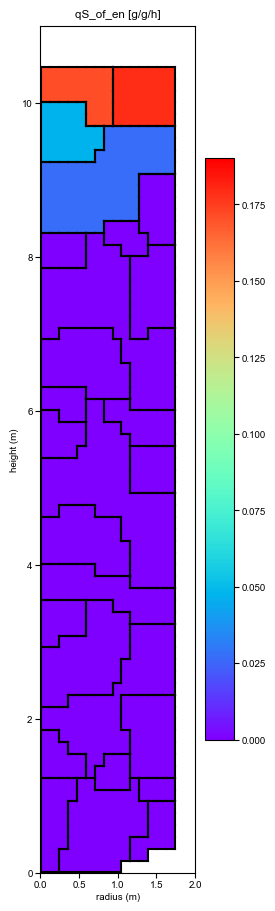

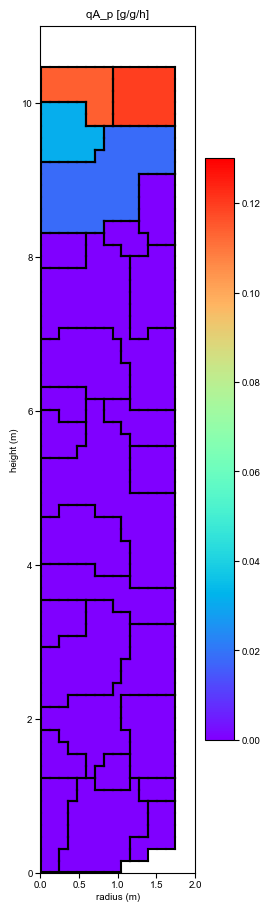

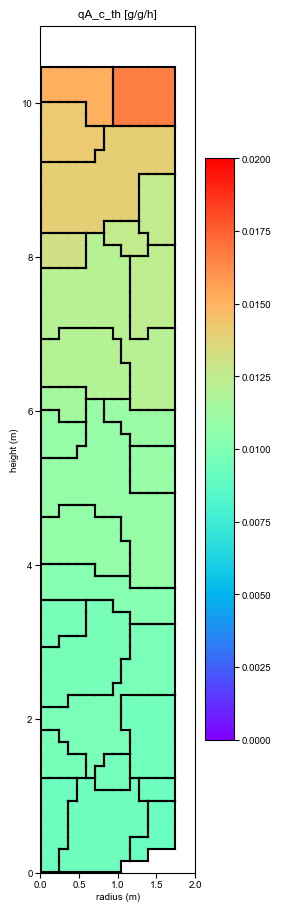

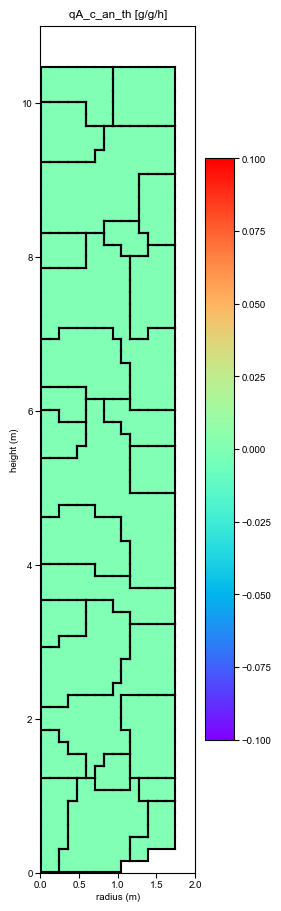

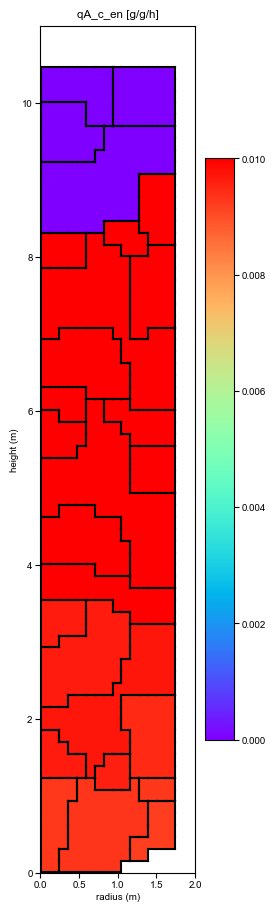

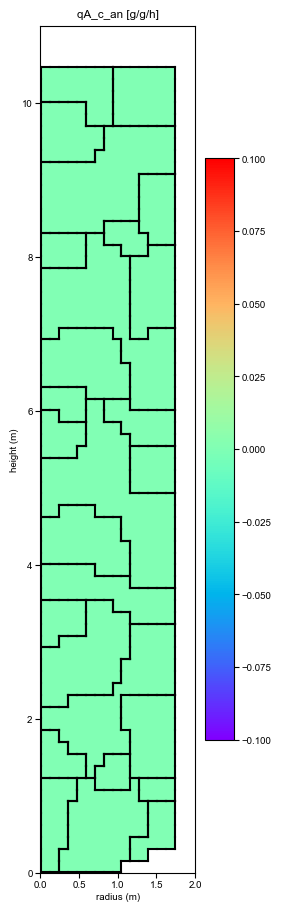

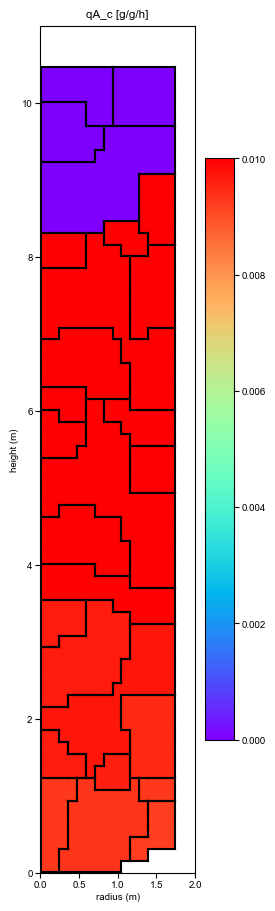

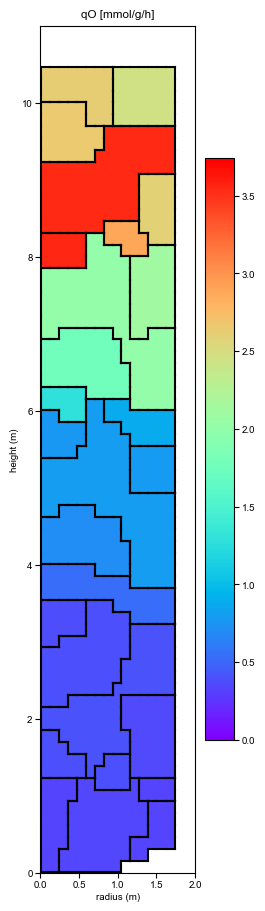

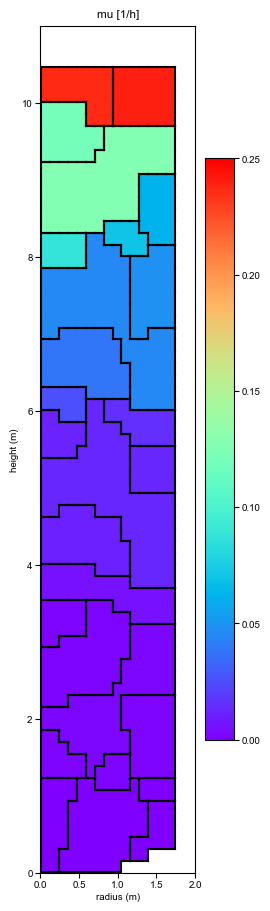

In [10]:
RTD_sol.plot_solution()

### Export solution DataFrame for inspection

In [11]:
RTD_sol.sol_df.to_excel("sol_df_45.xlsx")

### Calculate average solution accross the height of the bioreactor

In [12]:
CompMap = RTD_sol.cmodel['CompMap']

In [13]:
def calc_avg_solution(CompMap, RTD_sol, solution_string):
    
    average_Y_list = []
    compartment_value_list = []
    df = pd.DataFrame()
    
    for i in range(0,len(CompMap)):
    
        average_Y = (CompMap.loc[i].Y_min + CompMap.loc[i].Y_max)/2
        compartment = CompMap.loc[i].Zone
        compartment_value = RTD_sol.sol_df[RTD_sol.sol_df["comp_id"] == compartment][solution_string].values[0]
        
        average_Y_list.append(average_Y)
        compartment_value_list.append(compartment_value)
        
    df["Y"] = average_Y_list
    df["value"] = compartment_value_list
    
    df = df.groupby("Y").mean().reset_index()
    df = df.sort_values("Y")
        
    return df

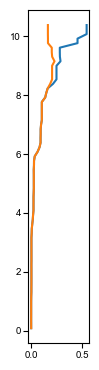

In [14]:
fig, ax = plt.subplots()

df = calc_avg_solution(CompMap, RTD_sol, "qS [g/g/h]")
ax.plot(df["value"], df["Y"])

df = calc_avg_solution(CompMap, RTD_sol, "qS_ox [g/g/h]")
ax.plot(df["value"], df["Y"])

# ax.set_title("qS [g/g/h]")

h=110/25.4
w=20/25.4
fig.set_size_inches(w=w,h=h)

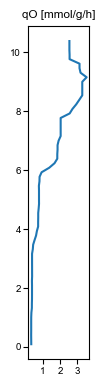

In [15]:
fig, ax = plt.subplots()

df = calc_avg_solution(CompMap, RTD_sol, "qO [mmol/g/h]")
ax.plot(df["value"], df["Y"])
ax.set_title("qO [mmol/g/h]")

h=110/25.4
w=20/25.4
fig.set_size_inches(w=w,h=h)

### Plot metabolic regimes

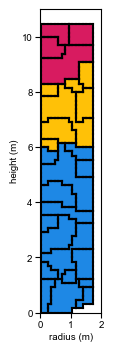

In [16]:
fig, ax = plt.subplots()

plot_reactor(RTD_sol, ax)

h=100/25.4
w=20/25.4
fig.set_size_inches(w=w,h=h)

### Plot selected results for prinitng

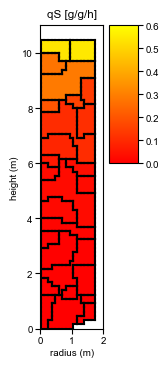

In [17]:
fig = plt.figure()

spec = fig.add_gridspec(nrows=2, ncols=3)

ax = fig.add_subplot(spec[:,:2])
cmap_ax = fig.add_subplot(spec[0,2])

variable_string = "qS [g/g/h]"
vmin = 0
v_max = 0.6
cmap = mpl.cm.autumn

plot_variabel_in_reactor_compartment(RTD_sol, fig, ax, variable_string, vmin, v_max, cmap, cmap_ax)

h=100/25.4
w=32/25.4
fig.set_size_inches(w=w,h=h)

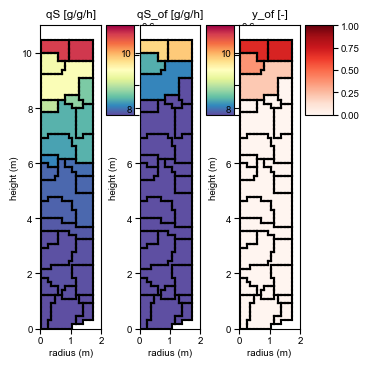

In [18]:
fig = plt.figure()

spec = fig.add_gridspec(nrows=3, ncols=9)

ax_1 = fig.add_subplot(spec[:,:2])
cmap_ax_1 = fig.add_subplot(spec[0,2])

ax_2 = fig.add_subplot(spec[:,3:5])
cmap_ax_2 = fig.add_subplot(spec[0,5])

ax_3 = fig.add_subplot(spec[:,6:8])
cmap_ax_3 = fig.add_subplot(spec[0,8])

### qS
variable_string = "qS [g/g/h]"
vmin = 0
v_max = 0.6
cmap = mpl.cm.Spectral_r

plot_variabel_in_reactor_compartment(RTD_sol, fig, ax_1, variable_string, vmin, v_max, cmap, cmap_ax_1)

### qS_of
variable_string = "qS_of [g/g/h]"
vmin = 0
v_max = 0.6
cmap = mpl.cm.Spectral_r

plot_variabel_in_reactor_compartment(RTD_sol, fig, ax_2, variable_string, vmin, v_max, cmap, cmap_ax_2)

### qS
RTD_sol.sol_df["y_of [-]"] = RTD_sol.sol_df["qS_of [g/g/h]"]/RTD_sol.sol_df["qS [g/g/h]"]
variable_string = "y_of [-]"
vmin = 0
v_max = 1.0
cmap = mpl.cm.Reds

plot_variabel_in_reactor_compartment(RTD_sol, fig, ax_3, variable_string, vmin, v_max, cmap, cmap_ax_3)

h=100/25.4
w=96/25.4
fig.set_size_inches(w=w,h=h)

# export figure as svg
plt.savefig("metabolic_rates_figure_raw.svg", dpi=900);

### Highlight compartment number inside map

C:\Users\jonas\AppData\Local\Temp\ipykernel_3216\1426935307.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('rainbow')


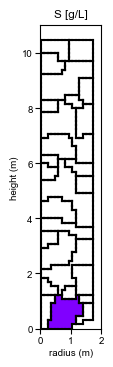

In [19]:
comp_n = 1

fig, ax = plt.subplots()

highlight_compartment(RTD_sol, ax, comp_n)

h=100/25.4
w=20/25.4
fig.set_size_inches(w=w,h=h)

## Scale-down design

### Concept figure

In [20]:
df1 = pd.DataFrame(columns=['t','F','air'])
df2 = pd.DataFrame(columns=['t','F','air'])
df3 = pd.DataFrame(columns=['t','F','air'])
df4 = pd.DataFrame(columns=['t','F','air'])

In [21]:
df1['t'] = [0,1]
df1['F'] = [1,1]
df1['air'] = [1,1]

df2['t'] = [0,0.38,0.38,1]
df2['F'] = [1,1,0,0]
df2['air'] = [1,1,1,1]

df3['t'] = [0,0.308,0.308,1]
df3['F'] = [1,1,1,1]
df3['air'] = [0,0,1,1]

df4['t'] = [0,0.263,0.263,0.38,0.38,1]
df4['F'] = [1,1,1,1,0,0]
df4['air'] = [1,1,0,0,1,1]

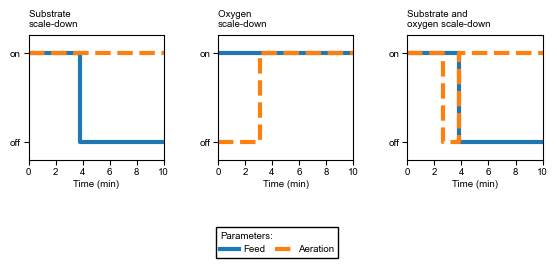

In [22]:
# figure size
height_cm =7.02
width_cm = 14.04

fig = plt.figure(figsize=(width_cm/2.54,height_cm/2.54))
spec = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[0, 2])

ax1.plot(df2['t'],df2['F'],label='Feed',linewidth=3)
ax1.plot(df2['t'],df2['air'],label='Aeration',linestyle='--',linewidth=3)

ax2.plot(df3['t'],df3['F'],label='Feed',linewidth=3)
ax2.plot(df3['t'],df3['air'],label='Aeration',linestyle='--',linewidth=3)

ax3.plot(df4['t'],df4['F'],label='Feed',linewidth=3)
ax3.plot(df4['t'],df4['air'],label='Aeration',linestyle='--',linewidth=3)

ax1.set_yticks([0,1])
ax2.set_yticks([0,1])
ax3.set_yticks([0,1])
ax1.set_ylim([-0.2,1.2])
ax2.set_ylim([-0.2,1.2])
ax3.set_ylim([-0.2,1.2])
ax1.set_yticklabels(['off','on'])
ax2.set_yticklabels(['off','on'])
ax3.set_yticklabels(['off','on'])

ax1.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax2.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax3.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax1.set_xlim([0,1])
ax2.set_xlim([0,1])
ax3.set_xlim([0,1])
ax1.set_xticklabels(['0','2','4','6','8','10'])
ax2.set_xticklabels(['0','2','4','6','8','10'])
ax3.set_xticklabels(['0','2','4','6','8','10'])

ax1.set_xlabel('Time (min)')
ax2.set_xlabel('Time (min)')
ax3.set_xlabel('Time (min)')

ax1.set_title('Substrate \nscale-down',loc='left',size=7)
ax2.set_title('Oxygen \nscale-down',loc='left',size=7)
ax3.set_title('Substrate and \noxygen scale-down',loc='left',size=7)

plt.subplots_adjust(wspace=0.4,left=0.05,right=0.98,top=0.85,bottom=0.4);

h,l = ax1.get_legend_handles_labels()
leg = fig.legend(h[:2], l[:2], bbox_to_anchor=[0.5, 0.1], loc='center', ncol=2, edgecolor='black',fancybox=False,columnspacing=1,handletextpad=0.4,title='Parameters:',framealpha=1)
leg._legend_box.align = "left"

### Combined Figure

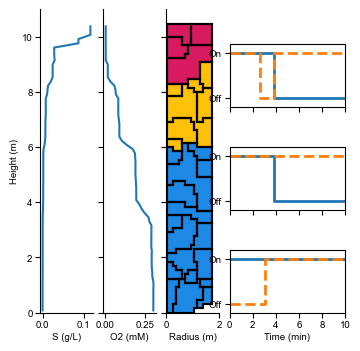

In [23]:
fig = plt.figure()

spec = fig.add_gridspec(nrows=9, ncols=5)

ax1 = fig.add_subplot(spec[:,0])
ax2 = fig.add_subplot(spec[:,1])
ax3 = fig.add_subplot(spec[:,2])

ax4 = fig.add_subplot(spec[1:3,3:])
ax5 = fig.add_subplot(spec[4:6,3:])
ax6 = fig.add_subplot(spec[7:,3:])

# Compartment map

plot_reactor(RTD_sol, ax3)
ax3.spines[['top','right']].set_visible(False)
ax3.set_ylabel("")
ax3.set_yticklabels([])
ax3.set_title("")
ax3.set_xlabel("Radius (m)")

y_0 = ax3.get_ylim()[0]
y_1 = ax3.get_ylim()[1]

# Substrate conc.

df = calc_avg_solution(CompMap, RTD_sol, "S [g/L]")
ax1.plot(df["value"], df["Y"])
ax1.set_xlabel("S (g/L)")
ax1.set_ylim(y_0, y_1)
ax1.set_ylabel("Height (m)")
ax1.spines[['top','right']].set_visible(False)

# Oxygen conc.

df = calc_avg_solution(CompMap, RTD_sol, "O [mmol/L]")
ax2.plot(df["value"], df["Y"])
ax2.set_xlabel("O2 (mM)")
ax2.set_ylim(y_0, y_1)
ax2.spines[['top','right']].set_visible(False)
ax2.set_yticklabels([]);

# Scale-down design

ax5.plot(df2['t'],df2['F'],label='Feed',linewidth=2)
ax5.plot(df2['t'],df2['air'],label='Aeration',linestyle='--',linewidth=2)

ax6.plot(df3['t'],df3['F'],label='Feed',linewidth=2)
ax6.plot(df3['t'],df3['air'],label='Aeration',linestyle='--',linewidth=2)

ax4.plot(df4['t'],df4['F'],label='Feed',linewidth=2)
ax4.plot(df4['t'],df4['air'],label='Aeration',linestyle='--',linewidth=2)

ax5.set_yticks([0,1])
ax6.set_yticks([0,1])
ax4.set_yticks([0,1])
ax5.set_ylim([-0.2,1.2])
ax6.set_ylim([-0.2,1.2])
ax4.set_ylim([-0.2,1.2])
ax5.set_yticklabels(['Off','On'])
ax6.set_yticklabels(['Off','On'])
ax4.set_yticklabels(['Off','On'])

ax5.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax6.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax4.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax5.set_xlim([0,1])
ax6.set_xlim([0,1])
ax4.set_xlim([0,1])
ax5.set_xticklabels([])
ax6.set_xticklabels(['0','2','4','6','8','10'])
ax4.set_xticklabels([])

# ax5.set_xlabel('Time (min)')
ax6.set_xlabel('Time (min)')
# ax4.set_xlabel('Time (min)')

h=100/25.4
w=100/25.4
fig.set_size_inches(w=w,h=h)

# export figure as svg
plt.savefig("Figure1_raw.svg", dpi=900);

### Design of a scale-down cycle

#### Model definition

In [24]:
from mmodels.xu_bb.im_xu_bb_for_scale_down import im_xu_bb

In [25]:
im_mmodel = im_xu_bb(
    strain_id='DDB7',
    strain_description= 'WT E. coli'
    )

im_mmodel.define_strain_params(
    qS_max=np.mean([0.78433, 0.76553]),
    qm_max=0,
    qA_c_max=np.mean([0.03444,0.03726]),
    qO_max=np.mean([6.7453,6.9238]),
    Ysx_ox=np.mean([0.43349, 0.44498]),
    Ysx_of=np.mean([0.43349, 0.44498]),
    Ysa=0.667,
    Yax=0.0,
    Ki_s=100,
    Ks=0.05,
    Ka=0.05,
    Ki_o=100
)

func = im_mmodel.im_bmodel_odes

#### Combined oscillations of feed and aeration

##### Setting controls

In [26]:
# Setting controls
## fp: function values of the controlled variable
## xp: timepoints in hours at which the control value is defined

## after 2.63 min the aeration was switched off
## after 3.8 min the aeration was switched back on and the feed was switched off

pulse_on_ratio = 3.8/10
D_set = 0.0086 # assuming a feed concentration of 500 g/L, the dilution rate D=F/V in the compartment model is 0.0086 1/h
D_on_value = D_set/pulse_on_ratio

kla_fp_array_control = [2000,2000,0,0,2000,2000]
kla_xp_array_control = [0, 2.63/60, 2.63/60, 3.8/60, 3.8/60, 10/60]

D_fp_array_control = [D_on_value, D_on_value, 0, 0]
D_xp_array_control = [0, 3.8/60, 3.8/60, 10/60]

##### Solving concentration

In [260]:
# process parameter function arguments
kla_fp_array = kla_fp_array_control
kla_xp_array = kla_xp_array_control
pabs = 1 # pabs [bar]
yO = 0.2095 # yO [-]
Sf = 500 # Sf [g/L]
D_fp_array = D_fp_array_control
D_xp_array = D_xp_array_control
V_fixed = True # assuming fixed volume because of snapshot simulation
X_fixed = True # assuming fixed biomass because of snapshot simulation
D_set = 0.0086 # assuming a feed concentration of 500 g/L, the dilution rate D=F/V in the compartment model is 0.0086 1/h
pulse_cycle_time = 10*60 # time in seconds
pulse_on_ratio = 3.8/10
returns = 'dydt'

y0 = [
    45,    # X [g/L]
    0,     # S [g/L]
    0.2095, # O [mol/L]
    0      # A [g/L]
]

# timesteps to evaluate
t_eval = np.linspace(0,10/60,500001)

args=(kla_fp_array,kla_xp_array,pabs,yO,Sf,D_fp_array,D_xp_array,V_fixed,X_fixed,D_set,pulse_cycle_time,pulse_on_ratio,returns)

so_conc_sol = odeint(func=func,y0=y0,tfirst=True,t=t_eval,args=args)        

Text(0.5, 1.0, 'Oxygen conc. [mM]')

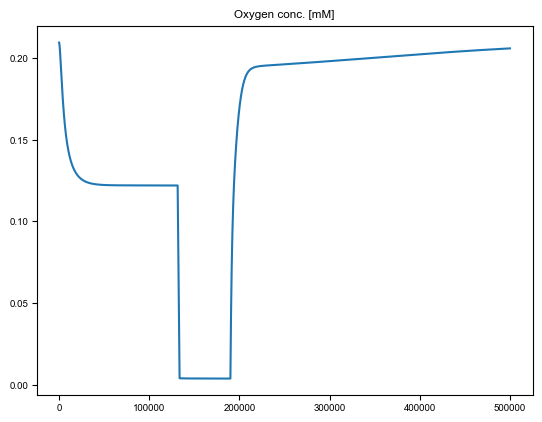

In [261]:
plt.plot(so_conc_sol[:,2]);
plt.title("Oxygen conc. [mM]")

##### Solving rates

In [262]:
im_mmodel.rates

,rate,description,unit
0,O_star,oxygen saturation concentration,[mmol/L]
1,OTR,oxygen transfer rate,[mmol/L/h]
2,qS,specific substrate uptake rate,[g/g/h]
3,qm,actual maintenance coefficient,[g/g/h]
4,qS_ox_an_th,theoretical specific substrate uptake rate of ...,[g/g/h]
5,qS_ox_en_th,theoretical specific substrate uptake rate of ...,[g/g/h]
6,OUC,oxygen uptake capacity,[mmol/g/h]
7,qO_s,specific oxygen uptake rate for substrate oxid...,[mmol/g/h]
8,qS_ox_en,specific substrate uptake rate of the energy o...,[g/g/h]
9,qS_ox_an,specific substrate uptake rate of the anabolic...,[g/g/h]


In [263]:
returns = 'rates'

so_rates_sol = im_mmodel.im_bmodel_odes(
    t_eval,
    so_conc_sol.T,
    kla_fp_array,
    kla_xp_array,
    pabs,
    yO,
    Sf,
    D_fp_array,
    D_xp_array,
    V_fixed,
    X_fixed,
    D_set,
    pulse_cycle_time,
    pulse_on_ratio,
    returns
)

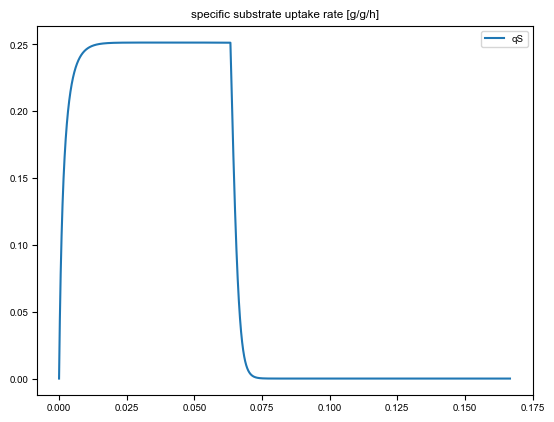

In [264]:
rate_id = 2
plt.plot(t_eval,so_rates_sol[rate_id][1],label=so_rates_sol[rate_id][0])
plt.legend()
plt.title(im_mmodel.rates.iloc[rate_id].description+" "+im_mmodel.rates.iloc[rate_id].unit);

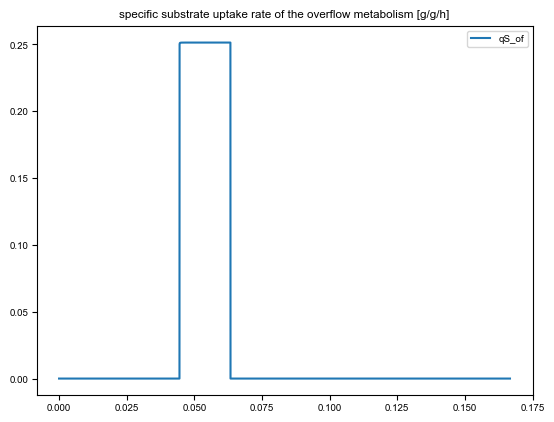

In [265]:
rate_id = 11
plt.plot(t_eval,so_rates_sol[rate_id][1],label=so_rates_sol[rate_id][0])
plt.legend()
plt.title(im_mmodel.rates.iloc[rate_id].description+" "+im_mmodel.rates.iloc[rate_id].unit);

#### Oscillations of feed

##### Setting controls

In [266]:
# Setting controls
## fp: function values of the controlled variable
## xp: timepoints in hours at which the control value is defined

## after 2.63 min the aeration was switched off
## after 3.8 min the aeration was switched back on and the feed was switched off

pulse_on_ratio = 3.8/10
D_set = 0.0086 # assuming a feed concentration of 500 g/L, the dilution rate D=F/V in the compartment model is 0.0086 1/h
D_on_value = D_set/pulse_on_ratio

kla_fp_array_control = [2000,2000]
kla_xp_array_control = [0, 10/60]

D_fp_array_control = [D_on_value, D_on_value, 0, 0]
D_xp_array_control = [0, 3.8/60, 3.8/60, 10/60]

##### Solving concentration

In [267]:
# process parameter function arguments
kla_fp_array = kla_fp_array_control
kla_xp_array = kla_xp_array_control
pabs = 1 # pabs [bar]
yO = 0.2095 # yO [-]
Sf = 500 # Sf [g/L]
D_fp_array = D_fp_array_control
D_xp_array = D_xp_array_control
V_fixed = True # assuming fixed volume because of snapshot simulation
X_fixed = True # assuming fixed biomass because of snapshot simulation
D_set = 0.0086 # assuming a feed concentration of 500 g/L, the dilution rate D=F/V in the compartment model is 0.0086 1/h
pulse_cycle_time = 10*60 # time in seconds
pulse_on_ratio = 3.8/10
returns = 'dydt'

y0 = [
    45,    # X [g/L]
    0,     # S [g/L]
    0.2095, # O [mol/L]
    0      # A [g/L]
]

# timesteps to evaluate
t_eval = np.linspace(0,10/60,10001)

args=(kla_fp_array,kla_xp_array,pabs,yO,Sf,D_fp_array,D_xp_array,V_fixed,X_fixed,D_set,pulse_cycle_time,pulse_on_ratio,returns)

s_conc_sol = odeint(func=func,y0=y0,tfirst=True,t=t_eval,args=args)        

Text(0.5, 1.0, 'Oxygen conc. [mM]')

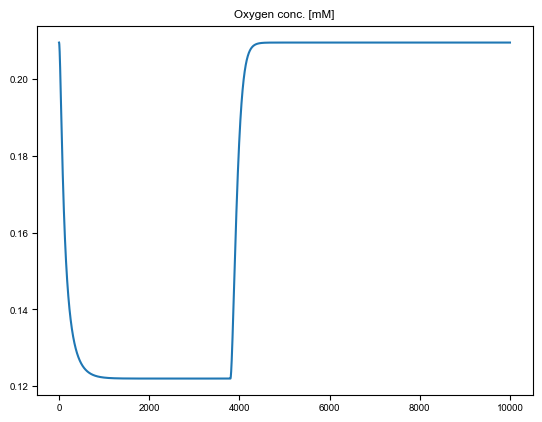

In [268]:
plt.plot(s_conc_sol[:,2]);
plt.title("Oxygen conc. [mM]")

##### Solving rates

In [269]:
im_mmodel.rates

,rate,description,unit
0,O_star,oxygen saturation concentration,[mmol/L]
1,OTR,oxygen transfer rate,[mmol/L/h]
2,qS,specific substrate uptake rate,[g/g/h]
3,qm,actual maintenance coefficient,[g/g/h]
4,qS_ox_an_th,theoretical specific substrate uptake rate of ...,[g/g/h]
5,qS_ox_en_th,theoretical specific substrate uptake rate of ...,[g/g/h]
6,OUC,oxygen uptake capacity,[mmol/g/h]
7,qO_s,specific oxygen uptake rate for substrate oxid...,[mmol/g/h]
8,qS_ox_en,specific substrate uptake rate of the energy o...,[g/g/h]
9,qS_ox_an,specific substrate uptake rate of the anabolic...,[g/g/h]


In [270]:
returns = 'rates'

s_rates_sol = im_mmodel.im_bmodel_odes(
    t_eval,
    s_conc_sol.T,
    kla_fp_array,
    kla_xp_array,
    pabs,
    yO,
    Sf,
    D_fp_array,
    D_xp_array,
    V_fixed,
    X_fixed,
    D_set,
    pulse_cycle_time,
    pulse_on_ratio,
    returns
)

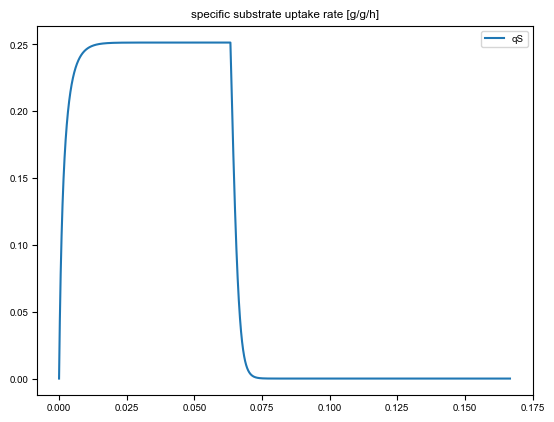

In [271]:
rate_id = 2
plt.plot(t_eval,s_rates_sol[rate_id][1],label=s_rates_sol[rate_id][0])
plt.legend()
plt.title(im_mmodel.rates.iloc[rate_id].description+" "+im_mmodel.rates.iloc[rate_id].unit);

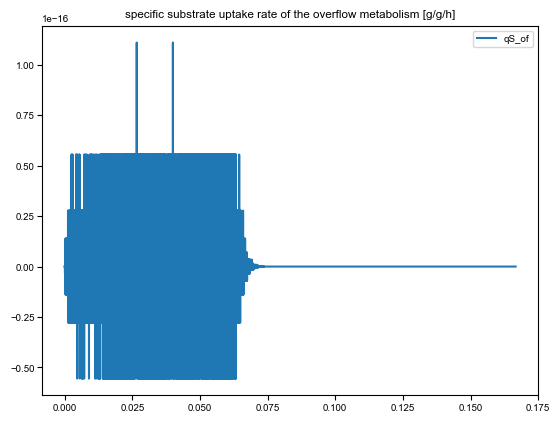

In [272]:
rate_id = 11
plt.plot(t_eval,s_rates_sol[rate_id][1],label=s_rates_sol[rate_id][0])
plt.legend()
plt.title(im_mmodel.rates.iloc[rate_id].description+" "+im_mmodel.rates.iloc[rate_id].unit);

#### Oscillations of aeration

##### Setting controls

In [273]:
# Setting controls
## fp: function values of the controlled variable
## xp: timepoints in hours at which the control value is defined

## after 2.63 min the aeration was switched off
## after 3.8 min the aeration was switched back on and the feed was switched off

pulse_on_ratio = 10/10
D_set = 0.0086 # assuming a feed concentration of 500 g/L, the dilution rate D=F/V in the compartment model is 0.0086 1/h
D_on_value = D_set/pulse_on_ratio

kla_fp_array_control = [0,0,2000,2000]
kla_xp_array_control = [0, 3.08/60, 3.08/60, 10/60]

D_fp_array_control = [D_on_value, D_on_value]
D_xp_array_control = [0, 10/60]

##### Solving concentration

In [274]:
# process parameter function arguments
kla_fp_array = kla_fp_array_control
kla_xp_array = kla_xp_array_control
pabs = 1 # pabs [bar]
yO = 0.2095 # yO [-]
Sf = 500 # Sf [g/L]
D_fp_array = D_fp_array_control
D_xp_array = D_xp_array_control
V_fixed = True # assuming fixed volume because of snapshot simulation
X_fixed = True # assuming fixed biomass because of snapshot simulation
D_set = 0.0086 # assuming a feed concentration of 500 g/L, the dilution rate D=F/V in the compartment model is 0.0086 1/h
pulse_cycle_time = 10*60 # time in seconds
pulse_on_ratio = 10/10
returns = 'dydt'

y0 = [
    45,    # X [g/L]
    0,     # S [g/L]
    0.2095, # O [mol/L]
    0      # A [g/L]
]

# timesteps to evaluate
t_eval = np.linspace(0,10/60,10001)

args=(kla_fp_array,kla_xp_array,pabs,yO,Sf,D_fp_array,D_xp_array,V_fixed,X_fixed,D_set,pulse_cycle_time,pulse_on_ratio,returns)

o_conc_sol = odeint(func=func,y0=y0,tfirst=True,t=t_eval,args=args)        

Text(0.5, 1.0, 'Oxygen conc. [mM]')

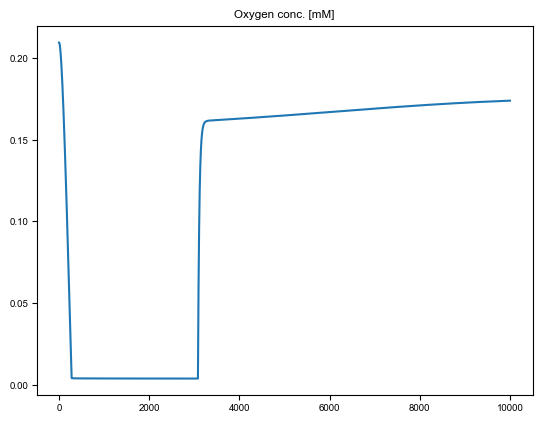

In [275]:
plt.plot(o_conc_sol[:,2]);
plt.title("Oxygen conc. [mM]")

##### Solving rates

In [276]:
im_mmodel.rates

,rate,description,unit
0,O_star,oxygen saturation concentration,[mmol/L]
1,OTR,oxygen transfer rate,[mmol/L/h]
2,qS,specific substrate uptake rate,[g/g/h]
3,qm,actual maintenance coefficient,[g/g/h]
4,qS_ox_an_th,theoretical specific substrate uptake rate of ...,[g/g/h]
5,qS_ox_en_th,theoretical specific substrate uptake rate of ...,[g/g/h]
6,OUC,oxygen uptake capacity,[mmol/g/h]
7,qO_s,specific oxygen uptake rate for substrate oxid...,[mmol/g/h]
8,qS_ox_en,specific substrate uptake rate of the energy o...,[g/g/h]
9,qS_ox_an,specific substrate uptake rate of the anabolic...,[g/g/h]


In [277]:
returns = 'rates'

o_rates_sol = im_mmodel.im_bmodel_odes(
    t_eval,
    o_conc_sol.T,
    kla_fp_array,
    kla_xp_array,
    pabs,
    yO,
    Sf,
    D_fp_array,
    D_xp_array,
    V_fixed,
    X_fixed,
    D_set,
    pulse_cycle_time,
    pulse_on_ratio,
    returns
)

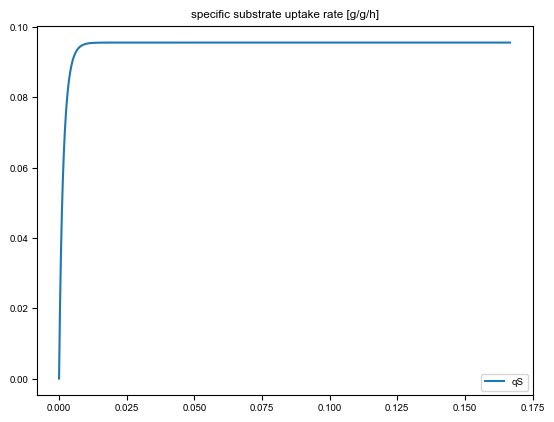

In [278]:
rate_id = 2
plt.plot(t_eval,o_rates_sol[rate_id][1],label=o_rates_sol[rate_id][0])
plt.legend()
plt.title(im_mmodel.rates.iloc[rate_id].description+" "+im_mmodel.rates.iloc[rate_id].unit);

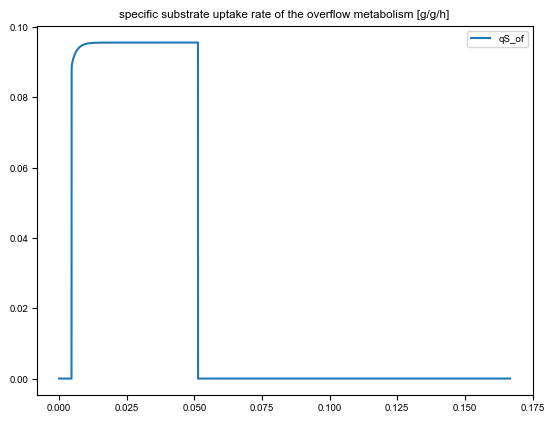

In [279]:
rate_id = 11
plt.plot(t_eval,o_rates_sol[rate_id][1],label=o_rates_sol[rate_id][0])
plt.legend()
plt.title(im_mmodel.rates.iloc[rate_id].description+" "+im_mmodel.rates.iloc[rate_id].unit);

#### Sensitivity analysis: Combined oscillations of feed and aeration

##### Setting controls

In [280]:
# Setting controls
## fp: function values of the controlled variable
## xp: timepoints in hours at which the control value is defined

## after 2.63 min the aeration was switched off
## after 3.8 min the aeration was switched back on and the feed was switched off

pulse_on_ratio = 3.8/10
D_set = 0.0086 # assuming a feed concentration of 500 g/L, the dilution rate D=F/V in the compartment model is 0.0086 1/h
D_on_value = D_set/pulse_on_ratio

kla_fp_array_control = [2000,2000,0,0,2000,2000]
kla_xp_array_control = [0, 2.63/60, 2.63/60, 3.8/60, 3.8/60, 10/60]

D_fp_array_control = [D_on_value, D_on_value, 0, 0]
D_xp_array_control = [0, 3.8/60, 3.8/60, 10/60]

##### iteration over biomass concentration

In [281]:
# process parameter function arguments
kla_fp_array = kla_fp_array_control
kla_xp_array = kla_xp_array_control
pabs = 1 # pabs [bar]
yO = 0.2095 # yO [-]
Sf = 500 # Sf [g/L]
D_fp_array = D_fp_array_control
D_xp_array = D_xp_array_control
V_fixed = True # assuming fixed volume because of snapshot simulation
X_fixed = True # assuming fixed biomass because of snapshot simulation
D_set = 0.0086 # assuming a feed concentration of 500 g/L, the dilution rate D=F/V in the compartment model is 0.0086 1/h
pulse_cycle_time = 10*60 # time in seconds
pulse_on_ratio = 3.8/10
returns = 'dydt'

df = pd.DataFrame()

X_list = []
avg_qS_list = []
avg_qS_of_list = []
y_of_list = []
y_starv_list = []

t_eval_list = [
    np.linspace(0,10/60,80001),
    np.linspace(0,10/60,220001),
    np.linspace(0,10/60,70001),
    np.linspace(0,10/60,10001),
    np.linspace(0,10/60,100001),
    np.linspace(0,10/60,500001)
]

args=(kla_fp_array,kla_xp_array,pabs,yO,Sf,D_fp_array,D_xp_array,V_fixed,X_fixed,D_set,pulse_cycle_time,pulse_on_ratio,returns)


for i,X in enumerate([20,25,30,35,40,45]):
    
    t_eval = t_eval_list[i]
    
    y0 = [
        X,    # X [g/L]
        0,     # S [g/L]
        0.2095, # O [mol/L]
        0      # A [g/L]
    ]

    vars()["so_conc_sol_"+str(X)] = odeint(func=func,y0=y0,tfirst=True,t=t_eval,args=args)        
    returns = 'rates'
    vars()["so_rates_sol_"+str(X)] = im_mmodel.im_bmodel_odes(
        t_eval,
        vars()["so_conc_sol_"+str(X)].T,
        kla_fp_array,
        kla_xp_array,
        pabs,
        yO,
        Sf,
        D_fp_array,
        D_xp_array,
        V_fixed,
        X_fixed,
        D_set,
        pulse_cycle_time,
        pulse_on_ratio,
        returns
    )
    
    avg_qS    = vars()["so_rates_sol_"+str(X)][2][1].mean()
    avg_qS_of = vars()["so_rates_sol_"+str(X)][11][1].mean()
    y_of      = avg_qS_of/avg_qS
    y_starv   = (vars()["so_rates_sol_"+str(X)][2][1] < 0.04).sum()/len(vars()["so_rates_sol_"+str(X)][2][1])
    
    X_list.append(X)
    avg_qS_list.append(avg_qS)
    avg_qS_of_list.append(avg_qS_of)
    y_of_list.append(y_of)
    y_starv_list.append(y_starv)
    
df["X"] = X_list
df["avg_qS"] = avg_qS_list
df["avg_qS_of"] = avg_qS_of_list
df["y_of"] = y_of_list
df["y_starv"] = y_starv_list

In [282]:
df

,X,avg_qS,avg_qS_of,y_of,y_starv
0,20,0.214960,0.071841,0.334205,0.503744
1,25,0.171979,0.050846,0.295652,0.550525
2,30,0.143319,0.042561,0.296965,0.573078
3,35,0.122837,0.036485,0.297023,0.585741
4,40,0.107493,0.031943,0.297167,0.593684
5,45,0.095551,0.028397,0.297188,0.599157


(0.0, 0.65)

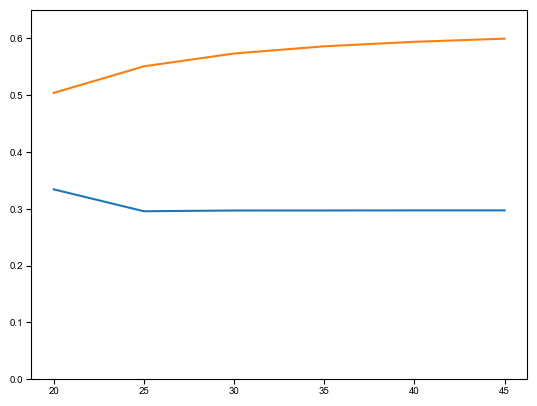

In [283]:
plt.plot(df["X"],df["y_of"])
plt.plot(df["X"],df["y_starv"])
plt.ylim(0,0.65)

### Summary figure

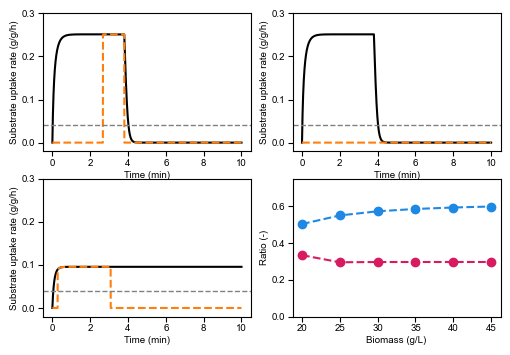

In [285]:
yellow_cb = '#FFC107'
blue_cb = '#1E88E5'
red_cb = '#D81B60'

fig = plt.figure()

spec = fig.add_gridspec(nrows=2, ncols=2)

ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[0,1])
ax3 = fig.add_subplot(spec[1,0])
ax4 = fig.add_subplot(spec[1,1])


t_eval = np.linspace(0,10/60,500001)
time_values = t_eval*60

ax1.plot(time_values,so_rates_sol[2][1],color="k")
ax1.plot(time_values,so_rates_sol[11][1],color="tab:orange",linestyle="--")
ax1.set_xlabel("Time (min)")
ax1.set_ylim(-0.02,0.3)
ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1])
ax1.hlines(y=0.04,xmin=ax1.get_xlim()[0],xmax=ax1.get_xlim()[1],linestyle="--",colors="grey",linewidths=1)
ax1.set_yticks([0.0,0.1,0.2,0.3])
ax1.set_ylabel("Substrate uptake rate (g/g/h)")

t_eval = np.linspace(0,10/60,10001)
time_values = t_eval*60

ax2.plot(time_values,s_rates_sol[2][1],color="k")
ax2.plot(time_values,s_rates_sol[11][1],color="tab:orange",linestyle="--")
ax2.set_xlabel("Time (min)")
ax2.set_ylim(-0.02,0.3)
ax2.set_xlim(ax2.get_xlim()[0], ax2.get_xlim()[1])
ax2.hlines(y=0.04,xmin=ax2.get_xlim()[0],xmax=ax2.get_xlim()[1],linestyle="--",colors="grey",linewidths=1)
ax2.set_yticks([0.0,0.1,0.2,0.3])
ax2.set_ylabel("Substrate uptake rate (g/g/h)")

t_eval = np.linspace(0,10/60,10001)
time_values = t_eval*60

ax3.plot(time_values,o_rates_sol[2][1],color="k")
ax3.plot(time_values,o_rates_sol[11][1],color="tab:orange",linestyle="--")
ax3.set_xlabel("Time (min)")
ax3.set_ylim(-0.02,0.3)
ax3.set_xlim(ax3.get_xlim()[0], ax3.get_xlim()[1])
ax3.hlines(y=0.04,xmin=ax3.get_xlim()[0],xmax=ax3.get_xlim()[1],linestyle="--",colors="grey",linewidths=1)
ax3.set_yticks([0.0,0.1,0.2,0.3])
ax3.set_ylabel("Substrate uptake rate (g/g/h)")

ax4.plot(df["X"],df["y_of"],marker="o",linestyle="--",color=red_cb)
ax4.plot(df["X"],df["y_starv"],marker="o",linestyle="--",color=blue_cb)
ax4.set_ylim(0,0.75)
ax4.set_xlabel("Biomass (g/L)")
ax4.set_ylabel("Ratio (-)")

h=100/25.4
w=150/25.4
fig.set_size_inches(w=w,h=h)

# export figure as svg
plt.savefig("Scale-down_design_figure_raw.svg", dpi=900);

In [302]:
# extract values from compartment model
RTD_sol.sol_df["rel_vol"] = RTD_sol.sol_df["liquid_vol [L]"]/RTD_sol.sol_df["liquid_vol [L]"].sum()

avg_qS_of_cm = (RTD_sol.sol_df["rel_vol"]*RTD_sol.sol_df["qS_of [g/g/h]"]).sum()
avg_qS_cm = (RTD_sol.sol_df["rel_vol"]*RTD_sol.sol_df["qS [g/g/h]"]).sum()

cm_y_of = avg_qS_of_cm/avg_qS_cm

cm_y_starv = RTD_sol.sol_df[RTD_sol.sol_df["qS [g/g/h]"] < 0.04]["rel_vol"].sum()

In [303]:
# extract values from S+O oscillation scale-down simulations
avg_qS    = so_rates_sol[2][1].mean()
avg_qS_of = so_rates_sol[11][1].mean()
y_of      = avg_qS_of/avg_qS
y_starv   = (so_rates_sol[2][1] < 0.04).sum()/len(so_rates_sol[2][1])

# create Dataframe for S+O oscillation scale-down
df_so = pd.DataFrame()
df_so["model"] = ["cm","cm","sd_design","sd_design"]
df_so["Ratio (-)"] = [cm_y_of,cm_y_starv,y_of,y_starv]
df_so["rate_type"] = ["anaerobic_ratio","starvation_ratio","anaerobic_ratio","starvation_ratio"] 

In [304]:
# extract values from S oscillation scale-down simulations
avg_qS    = s_rates_sol[2][1].mean()
avg_qS_of = s_rates_sol[11][1].mean()
y_of      = avg_qS_of/avg_qS
y_starv   = (s_rates_sol[2][1] < 0.04).sum()/len(s_rates_sol[2][1])

# create Dataframe for S+O oscillation scale-down
df_s = pd.DataFrame()
df_s["model"] = ["cm","cm","sd_design","sd_design"]
df_s["Ratio (-)"] = [cm_y_of,cm_y_starv,y_of,y_starv]
df_s["rate_type"] = ["anaerobic_ratio","starvation_ratio","anaerobic_ratio","starvation_ratio"] 

In [305]:
# extract values from S+O oscillation scale-down simulations
avg_qS    = o_rates_sol[2][1].mean()
avg_qS_of = o_rates_sol[11][1].mean()
y_of      = avg_qS_of/avg_qS
y_starv   = (o_rates_sol[2][1] < 0.04).sum()/len(o_rates_sol[2][1])

# create Dataframe for S+O oscillation scale-down
df_o = pd.DataFrame()
df_o["model"] = ["cm","cm","sd_design","sd_design"]
df_o["Ratio (-)"] = [cm_y_of,cm_y_starv,y_of,y_starv]
df_o["rate_type"] = ["anaerobic_ratio","starvation_ratio","anaerobic_ratio","starvation_ratio"] 

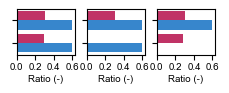

In [306]:
yellow_cb = '#FFC107'
blue_cb = '#1E88E5'
red_cb = '#D81B60'

fig = plt.figure()

spec = fig.add_gridspec(nrows=1, ncols=3)

ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[0,1])
ax3 = fig.add_subplot(spec[0,2])


sns.barplot(
    data=df_so,
    ax=ax1,
    y="model",
    x="Ratio (-)",
    hue="rate_type",
    hue_order=["anaerobic_ratio","starvation_ratio"],
    palette=[red_cb, blue_cb]
)
ax1.get_legend().remove()
ax1.set_ylabel("")
ax1.set_yticklabels([])
ax1.set_xticks([0,0.2,0.4,0.6])


sns.barplot(
    data=df_s,
    ax=ax2,
    y="model",
    x="Ratio (-)",
    hue="rate_type",
    hue_order=["anaerobic_ratio","starvation_ratio"],
    palette=[red_cb, blue_cb]
)
ax2.get_legend().remove()
ax2.set_ylabel("")
ax2.set_yticklabels([])
ax2.set_xticks([0,0.2,0.4,0.6])


sns.barplot(
    data=df_o,
    ax=ax3,
    y="model",
    x="Ratio (-)",
    hue="rate_type",
    hue_order=["anaerobic_ratio","starvation_ratio"],
    palette=[red_cb, blue_cb]
)
ax3.get_legend().remove()
ax3.set_ylabel("")
ax3.set_yticklabels([])
ax3.set_xticks([0,0.2,0.4,0.6])


h=15/25.4
w=65/25.4
fig.set_size_inches(w=w,h=h)

# export figure as svg
plt.savefig("Scale-down_design_ratios_figure_raw.svg", dpi=900);

## Concept of E. coli metabolic regimes

In [317]:
df = pd.read_excel("metabolic_regimes.xlsx", sheet_name="Sheet2")

In [318]:
df

,qS,qm_1,qS_ox_an_th,qS_ox_en_th,OUC,qO_s,qS_ox_en,qm_2,qS_ox_an,qS_ox,...,qS_of_en,qA_p,qA_c_th,qA_c_an_th,qA_c_en,qA_c_an,qA_c,qO,mu,y_of
0,0.1,0.04,0.037317,0.062683,0.0,0.000000,0.000000,0.00,0.000000,0.000000,...,0.081707,0.054472,0,0,0,0,0,0.000000,-0.005400,1.000000
1,0.3,0.04,0.161707,0.138293,0.0,0.000000,0.000000,0.00,0.000000,0.000000,...,0.245122,0.163415,0,0,0,0,0,0.000000,0.024600,1.000000
2,0.5,0.04,0.286098,0.213902,0.0,0.000000,0.000000,0.00,0.000000,0.000000,...,0.408537,0.272358,0,0,0,0,0,0.000000,0.054600,1.000000
3,0.7,0.04,0.410488,0.289512,0.0,0.000000,0.000000,0.00,0.000000,0.000000,...,0.571951,0.381301,0,0,0,0,0,0.000000,0.084600,1.000000
4,0.9,0.04,0.534878,0.365122,0.0,0.000000,0.000000,0.00,0.000000,0.000000,...,0.735366,0.490244,0,0,0,0,0,0.000000,0.114600,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.5,0.04,0.286098,0.213902,15.6,7.122951,0.213902,0.04,0.286098,0.500000,...,0.000000,0.000000,0,0,0,0,0,7.122951,0.234600,0.000000
115,0.7,0.04,0.410488,0.289512,15.6,9.640756,0.289512,0.04,0.410488,0.700000,...,0.000000,0.000000,0,0,0,0,0,9.640756,0.336600,0.000000
116,0.9,0.04,0.534878,0.365122,15.6,12.158561,0.365122,0.04,0.534878,0.900000,...,0.000000,0.000000,0,0,0,0,0,12.158561,0.438600,0.000000
117,1.1,0.04,0.659268,0.440732,15.6,14.676366,0.440732,0.04,0.659268,1.100000,...,0.000000,0.000000,0,0,0,0,0,14.676366,0.540600,0.000000


In [344]:
Yso  = 12.58902439
qO_0 = 0.828439024
qS_1 = qO_0+1.4*Yso

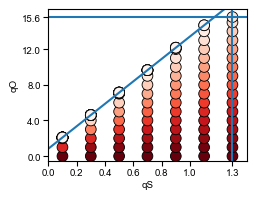

In [361]:
fig, ax = plt.subplots()

sns.scatterplot(
    data = df,
    x = "qS",
    y = "qO",
    hue = "y_of",
    palette = "Reds",
    s =60,
    edgecolor="k"
)

ax.set_xlim(0,1.4)
ax.set_ylim(-0.5,16.5)
ax.get_legend().remove()

ax.hlines(y=15.6, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1])
ax.vlines(x=1.3, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1])
ax.plot([0,1.4], [qO_0,qS_1])

ax.set_xticks([0,0.2,0.4,0.6,0.8,1.0,1.3])
ax.set_yticks([0,4,8,12,15.6])

h=50/25.4
w=65/25.4
fig.set_size_inches(w=w,h=h)

# export figure as svg
plt.savefig("metabolic_regimes_Xu_figure_raw.svg", dpi=900);